#  Airbnb Price Prediction with MLflow and AWS S3

**Complete Implementation in One Notebook**

---

## Project Overview

This notebook implements an end-to-end machine learning pipeline for predicting Airbnb listing prices in NYC.

**What this notebook does:**
1. Data loading from AWS S3 or local file
2. Comprehensive data preprocessing
3. Feature engineering
4. Training 8 different ML models
5. MLflow experiment tracking
6. Model comparison and selection
7. Visualization generation

**Author**: Rajan   
**Institution**: Lambton College

---

## 1. Installation and Setup

**Run this cell first to install all required packages**

In [70]:
# !pip install numpy pandas scikit-learn xgboost mlflow boto3 matplotlib seaborn python-dotenv -q

## 2. Import Libraries

In [ ]:
# Standard libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from datetime import datetime
from dotenv import load_dotenv

# AWS and MLflow
import boto3
from io import StringIO
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Settings
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 3. Configuration

In [16]:
# Project configuration
EXPERIMENT_NAME = "airbnb_price_prediction"
TEST_SIZE = 0.2
RANDOM_STATE = 42

# File paths 
# DATA_FILE_PATH = 'AB_NYC_2019.csv' 

# AWS S3 Configuration 
load_dotenv()

bucket_name = os.getenv("S3_BUCKET_NAME")
region = os.getenv("AWS_REGION")

print("Bucket:", bucket_name)

# Create S3 client
s3 = boto3.client("s3", region_name=region)

# Read file directly into memory
response = s3.get_object(Bucket=bucket_name, Key="AB NYC 2019 Assessment 2.csv")
df = pd.read_csv(response['Body'])

# Create directories
os.makedirs('visualizations', exist_ok=True)
os.makedirs('models', exist_ok=True)

print(f"Configuration set")
print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Test Size: {TEST_SIZE}")
print(f"Random State: {RANDOM_STATE}")

Bucket: ml-ops-lambton-bucket
Configuration set
Experiment: airbnb_price_prediction
Test Size: 0.2
Random State: 42


In [17]:
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


## 4. Data Loading

###  Load from Local File

In [ ]:
# Load data from local file
def load_data_local(filepath):
    """
    Load dataset from local file
    
    Parameters:
    -----------
    filepath : str
        Path to the CSV file
    
    Returns:
    --------
    DataFrame
    """
    try:
        df = pd.read_csv(filepath)
        print(f"Successfully loaded data from local file")
        print(f"Path: {filepath}")
        print(f"Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading file: {str(e)}")
        raise

# Load the data
# df = load_data_local(DATA_FILE_PATH)
# df.head()

### Option 2: Load from AWS S3 (Optional)

In [71]:
def load_data_from_s3(bucket_name, file_key):
    """
    Load dataset from AWS S3
    
    Parameters:
    -----------
    bucket_name : str
        Name of the S3 bucket
    file_key : str
        Path to the file in S3
    
    Returns:
    --------
    DataFrame
    """
    try:
        s3_client = boto3.client('s3')
        response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
        csv_content = response['Body'].read().decode('utf-8')
        df = pd.read_csv(StringIO(csv_content))
        print(f"Successfully loaded data from S3")
        print(f"Bucket: {bucket_name}")
        print(f"File: {file_key}")
        print(f"Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading from S3: {str(e)}")
        raise

# # Load from S3
# df = load_data_from_s3(S3_BUCKET_NAME, S3_FILE_KEY)

## 5. Exploratory Data Analysis (EDA)

In [20]:
# Dataset overview
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nRows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")
print(f"\nColumn Names:")
print(df.columns.tolist())

DATASET OVERVIEW

Rows: 48,895
Columns: 16

Column Names:
['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


In [21]:
# Data types and info
print("\nDATA TYPES AND INFO:")
print("="*60)
df.info()


DATA TYPES AND INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_revie

In [22]:
# Statistical summary
print("\nSTATISTICAL SUMMARY:")
print("="*60)
df.describe()


STATISTICAL SUMMARY:


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [23]:
# Missing values analysis
print("\nMISSING VALUES ANALYSIS:")
print("="*60)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))


MISSING VALUES ANALYSIS:
                   Missing Count  Percentage
last_review                10052   20.558339
reviews_per_month          10052   20.558339
host_name                     21    0.042949
name                          16    0.032723


In [24]:
# Target variable (Price) analysis
print("\nTARGET VARIABLE (PRICE) ANALYSIS:")
print("="*60)
print(df['price'].describe())
print(f"\nPrice Range: ${df['price'].min()} - ${df['price'].max()}")
print(f"Median Price: ${df['price'].median()}")
print(f"Mean Price: ${df['price'].mean():.2f}")


TARGET VARIABLE (PRICE) ANALYSIS:
count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Price Range: $0 - $10000
Median Price: $106.0
Mean Price: $152.72


In [25]:
# Categorical variables distribution
print("\nCATEGORICAL VARIABLES DISTRIBUTION:")
print("="*60)

categorical_cols = ['neighbourhood_group', 'room_type']
for col in categorical_cols:
    print(f"\n{col.upper()}:")
    print(df[col].value_counts())
    print(f"\nPercentage Distribution:")
    print((df[col].value_counts(normalize=True) * 100).round(2))


CATEGORICAL VARIABLES DISTRIBUTION:

NEIGHBOURHOOD_GROUP:
neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

Percentage Distribution:
neighbourhood_group
Manhattan        44.30
Brooklyn         41.12
Queens           11.59
Bronx             2.23
Staten Island     0.76
Name: proportion, dtype: float64

ROOM_TYPE:
room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64

Percentage Distribution:
room_type
Entire home/apt    51.97
Private room       45.66
Shared room         2.37
Name: proportion, dtype: float64


### Visualization: Price Distribution

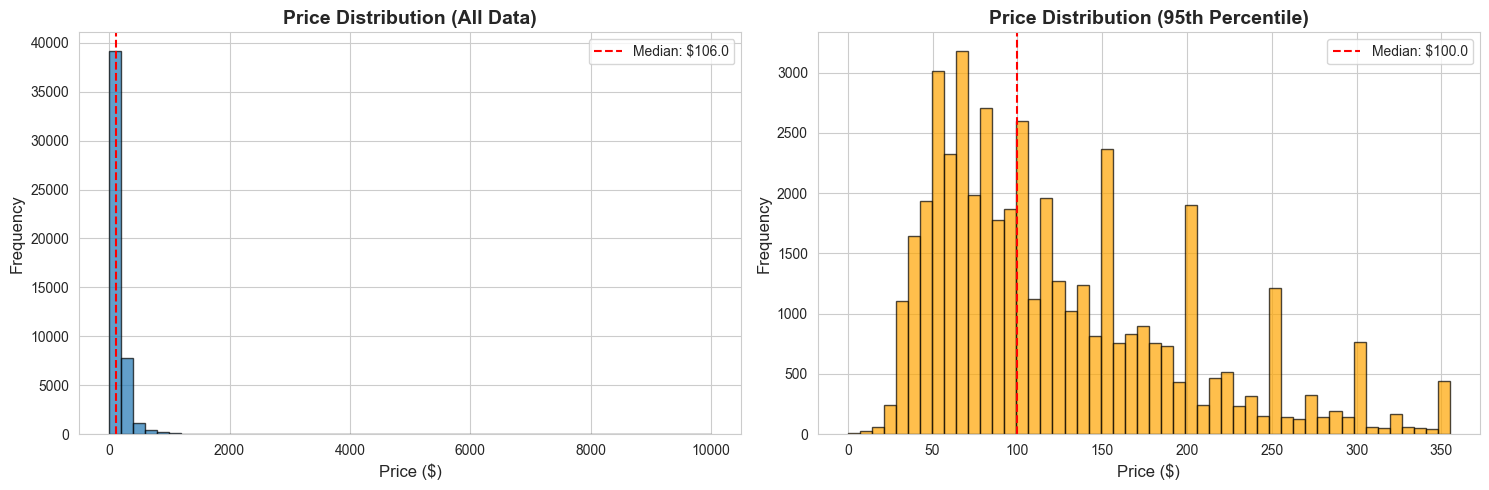

Price distribution plot saved to 'visualizations/price_distribution.png'


In [26]:
# Price distribution plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Full distribution
axes[0].hist(df['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Price Distribution (All Data)', fontsize=14, fontweight='bold')
axes[0].axvline(df['price'].median(), color='red', linestyle='--', label=f"Median: ${df['price'].median()}")
axes[0].legend()

# Filtered distribution (95th percentile)
price_filtered = df[df['price'] <= df['price'].quantile(0.95)]['price']
axes[1].hist(price_filtered, bins=50, edgecolor='black', color='orange', alpha=0.7)
axes[1].set_xlabel('Price ($)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Price Distribution (95th Percentile)', fontsize=14, fontweight='bold')
axes[1].axvline(price_filtered.median(), color='red', linestyle='--', label=f"Median: ${price_filtered.median()}")
axes[1].legend()

plt.tight_layout()
plt.savefig('visualizations/price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Price distribution plot saved to 'visualizations/price_distribution.png'")

### Visualization: Categorical Variables

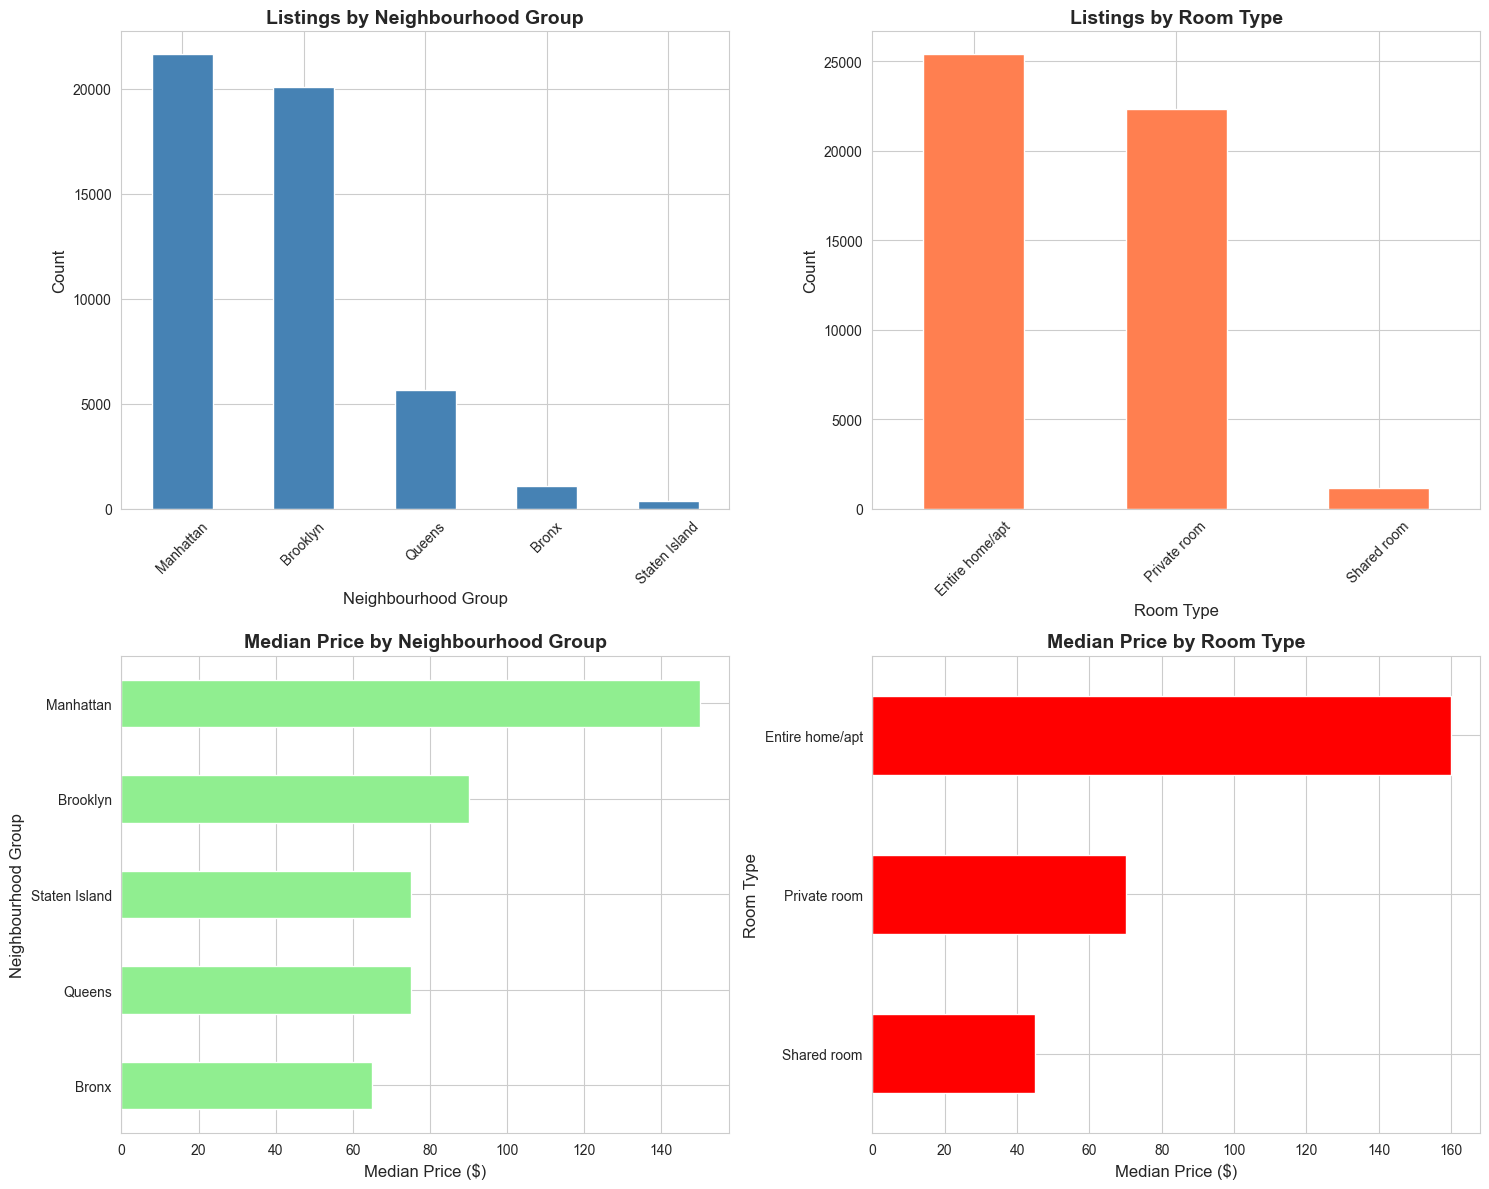

Categorical analysis plot saved to 'visualizations/categorical_analysis.png'


In [42]:
# Categorical variables plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Neighbourhood Group
df['neighbourhood_group'].value_counts().plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Listings by Neighbourhood Group', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Neighbourhood Group', fontsize=12)
axes[0, 0].set_ylabel('Count', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)

# Room Type
df['room_type'].value_counts().plot(kind='bar', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Listings by Room Type', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Room Type', fontsize=12)
axes[0, 1].set_ylabel('Count', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45)

# Price by Neighbourhood Group
df.groupby('neighbourhood_group')['price'].median().sort_values().plot(
    kind='barh', ax=axes[1, 0], color='lightgreen'
)
axes[1, 0].set_title('Median Price by Neighbourhood Group', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Median Price ($)', fontsize=12)
axes[1, 0].set_ylabel('Neighbourhood Group', fontsize=12)

# Price by Room Type
df.groupby('room_type')['price'].median().sort_values().plot(
    kind='barh', ax=axes[1, 1], color='red'
)
axes[1, 1].set_title('Median Price by Room Type', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Median Price ($)', fontsize=12)
axes[1, 1].set_ylabel('Room Type', fontsize=12)

plt.tight_layout()
plt.savefig('visualizations/categorical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Categorical analysis plot saved to 'visualizations/categorical_analysis.png'")

## 6. Data Preprocessing

### Handle Missing Values

In [28]:
# Create a copy for preprocessing
df_clean = df.copy()

print("="*60)
print("DATA PREPROCESSING")
print("="*60)
print(f"\nInitial shape: {df_clean.shape}")

# Drop rows with missing target variable
initial_rows = len(df_clean)
df_clean = df_clean[df_clean['price'].notna()]
print(f"\n1. Handling Missing Target:")
print(f"   Dropped {initial_rows - len(df_clean)} rows with missing price")

# Fill missing reviews data
df_clean['reviews_per_month'].fillna(0, inplace=True)
df_clean['last_review'].fillna('Unknown', inplace=True)
print(f"\n2. Handling Missing Reviews:")
print(f"Filled missing reviews_per_month with 0")
print(f"Filled missing last_review with 'Unknown'")

DATA PREPROCESSING

Initial shape: (48895, 16)

1. Handling Missing Target:
   Dropped 0 rows with missing price

2. Handling Missing Reviews:
Filled missing reviews_per_month with 0
Filled missing last_review with 'Unknown'


### Handle Outliers

In [29]:
print(f"\n3. Handling Outliers:")
print("="*60)

# Remove price outliers
initial_rows = len(df_clean)
df_clean = df_clean[(df_clean['price'] > 0) & (df_clean['price'] <= 10000)]
print(f"   Price outliers removed: {initial_rows - len(df_clean)} rows")
print(f"   (Kept prices between $0 and $10,000)")

# Handle minimum_nights outliers
initial_rows = len(df_clean)
df_clean = df_clean[df_clean['minimum_nights'] <= 365]
print(f"Minimum nights outliers removed: {initial_rows - len(df_clean)} rows")
print(f"(Kept minimum_nights <= 365)")

print(f"\nFinal shape after cleaning: {df_clean.shape}")
print(f"Total rows removed: {df.shape[0] - df_clean.shape[0]} ({((df.shape[0] - df_clean.shape[0])/df.shape[0]*100):.2f}%)")


3. Handling Outliers:
   Price outliers removed: 11 rows
   (Kept prices between $0 and $10,000)
Minimum nights outliers removed: 14 rows
(Kept minimum_nights <= 365)

Final shape after cleaning: (48870, 16)
Total rows removed: 25 (0.05%)


## 7. Feature Engineering

In [32]:
print("="*60)
print("FEATURE ENGINEERING")
print("="*60)

# 1. Has reviews indicator
df_clean['has_reviews'] = (df_clean['number_of_reviews'] > 0).astype(int)
print("\n1. Created 'has_reviews' - Binary indicator for listings with reviews")

# 2. Review score (engagement metric)
df_clean['review_score'] = df_clean['number_of_reviews'] * df_clean['reviews_per_month']
df_clean['review_score'].fillna(0, inplace=True)
print("2. Created 'review_score' - Review engagement metric")

# 3. Host activity categorization
df_clean['host_activity'] = pd.cut(
    df_clean['calculated_host_listings_count'],
    bins=[0, 1, 5, 20, 1000],
    labels=['Single', 'Small', 'Medium', 'Large']
)
print("3. Created 'host_activity' - Host portfolio size category")

# 4. Availability categorization
df_clean['availability_category'] = pd.cut(
    df_clean['availability_365'],
    bins=[0, 90, 180, 270, 365],
    labels=['Low', 'Medium', 'High', 'Very High']
)
print("4. Created 'availability_category' - Availability level")

# 5. Price category (for analysis)
df_clean['price_category'] = pd.cut(
    df_clean['price'],
    bins=[0, 70, 150, 300, 10000],
    labels=['Budget', 'Mid-range', 'Premium', 'Luxury']
)
print("5. Created 'price_category' - Price tier classification")

print(f"\n Feature engineering completed")
print(f"  Total columns now: {len(df_clean.columns)}")
print(f"  New features created: 5")

FEATURE ENGINEERING

1. Created 'has_reviews' - Binary indicator for listings with reviews
2. Created 'review_score' - Review engagement metric
3. Created 'host_activity' - Host portfolio size category
4. Created 'availability_category' - Availability level
5. Created 'price_category' - Price tier classification

 Feature engineering completed
  Total columns now: 21
  New features created: 5


In [33]:
# Display new features
print("\nNew Features Summary:")
print("="*60)
new_features = ['has_reviews', 'review_score', 'host_activity', 'availability_category', 'price_category']
for feature in new_features:
    if df_clean[feature].dtype == 'object' or df_clean[feature].dtype.name == 'category':
        print(f"\n{feature}:")
        print(df_clean[feature].value_counts())
    else:
        print(f"\n{feature}: {df_clean[feature].describe()[['mean', '50%', 'max']]}")


New Features Summary:

has_reviews: mean    0.794496
50%     1.000000
max     1.000000
Name: has_reviews, dtype: float64

review_score: mean      67.336742
50%        2.070000
max     9170.820000
Name: review_score, dtype: float64

host_activity:
host_activity
Single    32288
Small     11792
Medium     2585
Large      2205
Name: count, dtype: int64

availability_category:
availability_category
Low          11708
Very High     9840
Medium        5282
High          4510
Name: count, dtype: int64

price_category:
price_category
Mid-range    20409
Budget       13527
Premium      11578
Luxury        3356
Name: count, dtype: int64


## 8. Feature Selection and Preparation

In [34]:
print("="*60)
print("FEATURE PREPARATION")
print("="*60)

# Define features
numeric_features = [
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'has_reviews',
    'review_score'
]

categorical_features = [
    'neighbourhood_group',
    'neighbourhood',
    'room_type',
    'host_activity',
    'availability_category'
]

print(f"\n1. Feature Selection:")
print(f"   Numeric features: {len(numeric_features)}")
print(f"   Categorical features: {len(categorical_features)}")
print(f"   Total features: {len(numeric_features) + len(categorical_features)}")

print(f"\n   Numeric Features:")
for i, feat in enumerate(numeric_features, 1):
    print(f"     {i}. {feat}")

print(f"\n   Categorical Features:")
for i, feat in enumerate(categorical_features, 1):
    print(f"     {i}. {feat}")

FEATURE PREPARATION

1. Feature Selection:
   Numeric features: 9
   Categorical features: 5
   Total features: 14

   Numeric Features:
     1. latitude
     2. longitude
     3. minimum_nights
     4. number_of_reviews
     5. reviews_per_month
     6. calculated_host_listings_count
     7. availability_365
     8. has_reviews
     9. review_score

   Categorical Features:
     1. neighbourhood_group
     2. neighbourhood
     3. room_type
     4. host_activity
     5. availability_category


In [35]:
# Select features and target
X = df_clean[numeric_features + categorical_features].copy()
y = df_clean['price'].copy()

print(f"\n2. Dataset Split:")
print(f"   Features (X) shape: {X.shape}")
print(f"   Target (y) shape: {y.shape}")


2. Dataset Split:
   Features (X) shape: (48870, 14)
   Target (y) shape: (48870,)


In [36]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"\n3. Train-Test Split:")
print(f"   Training samples: {len(X_train):,} ({(1-TEST_SIZE)*100:.0f}%)")
print(f"   Testing samples: {len(X_test):,} ({TEST_SIZE*100:.0f}%)")
print(f"   Split ratio: {int((1-TEST_SIZE)*100)}-{int(TEST_SIZE*100)}")


3. Train-Test Split:
   Training samples: 39,096 (80%)
   Testing samples: 9,774 (20%)
   Split ratio: 80-20


###  Preprocessing Pipeline

In [40]:
# Create preprocessing transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("\n4. Preprocessing Pipeline Created:")
print("     Numeric: Median Imputation → Standard Scaling")
print("     Categorical: Constant Imputation → One-Hot Encoding")
print(" Feature preparation completed successfully!")


4. Preprocessing Pipeline Created:
     Numeric: Median Imputation → Standard Scaling
     Categorical: Constant Imputation → One-Hot Encoding
 Feature preparation completed successfully!


## 9. MLflow Setup

In [43]:
# Set MLflow experiment
mlflow.set_experiment(EXPERIMENT_NAME)

print("="*60)
print("MLFLOW EXPERIMENT TRACKING SETUP")
print("="*60)
print(f"\n MLflow experiment set to: '{EXPERIMENT_NAME}'")
print(f"  Tracking URI: {mlflow.get_tracking_uri()}")
print(f"  Artifact Location: {mlflow.get_experiment_by_name(EXPERIMENT_NAME).artifact_location}")
print("\nAll model training runs will be logged to MLflow!")

2025/11/20 19:39:31 INFO mlflow.tracking.fluent: Experiment with name 'airbnb_price_prediction' does not exist. Creating a new experiment.


MLFLOW EXPERIMENT TRACKING SETUP

 MLflow experiment set to: 'airbnb_price_prediction'
  Tracking URI: file:///Users/rajan/Projects/AML-3303/Predicting-Airbnb-Listing-Prices-with-MLflow-and-AWS-S3/mlruns
  Artifact Location: file:///Users/rajan/Projects/AML-3303/Predicting-Airbnb-Listing-Prices-with-MLflow-and-AWS-S3/mlruns/416135146092517914

All model training runs will be logged to MLflow!


## 10. Model Training Functions

In [45]:
def train_and_log_model(model, model_name, hyperparameters=None):
    """
    Train a model and log everything to MLflow
    
    Parameters:
    -----------
    model : sklearn estimator
        The model to train
    model_name : str
        Name for the MLflow run
    hyperparameters : dict, optional
        Hyperparameters for GridSearchCV
    
    Returns:
    --------
    tuple : (trained_pipeline, test_rmse, test_r2)
    """
    with mlflow.start_run(run_name=model_name):
        # Create full pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Hyperparameter tuning if specified
        if hyperparameters:
            print(f"   Performing GridSearchCV...")
            grid_search = GridSearchCV(
                pipeline,
                hyperparameters,
                cv=3,
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            grid_search.fit(X_train, y_train)
            pipeline = grid_search.best_estimator_
            
            # Log best parameters
            mlflow.log_params(grid_search.best_params_)
            print(f"   Best parameters: {grid_search.best_params_}")
        else:
            pipeline.fit(X_train, y_train)
        
        # Predictions
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        # Log metrics to MLflow
        mlflow.log_metric("train_rmse", train_rmse)
        mlflow.log_metric("test_rmse", test_rmse)
        mlflow.log_metric("train_mae", train_mae)
        mlflow.log_metric("test_mae", test_mae)
        mlflow.log_metric("train_r2", train_r2)
        mlflow.log_metric("test_r2", test_r2)
        
        # Log parameters
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("train_samples", len(X_train))
        mlflow.log_param("test_samples", len(X_test))
        mlflow.log_param("random_state", RANDOM_STATE)
        
        # Log model
        signature = infer_signature(X_train, y_train_pred)
        mlflow.sklearn.log_model(pipeline, "model", signature=signature)
        
        # Print results
        print(f"\n   {model_name} Results:")
        print(f"   {'='*50}")
        print(f"   Train RMSE: ${train_rmse:8.2f} | Test RMSE: ${test_rmse:8.2f}")
        print(f"   Train MAE:  ${train_mae:8.2f} | Test MAE:  ${test_mae:8.2f}")
        print(f"   Train R²:   {train_r2:9.4f} | Test R²:   {test_r2:9.4f}")
        
        return pipeline, test_rmse, test_r2

## 11. Train All Models

### Model 1: Linear Regression

In [46]:
print("\n" + "="*60)
print("MODEL 1: LINEAR REGRESSION")
print("="*60)

results = []
model, rmse, r2 = train_and_log_model(LinearRegression(), "Linear Regression")
results.append({'Model': 'Linear Regression', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 1: LINEAR REGRESSION


2025/11/20 19:39:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 19:40:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   Linear Regression Results:
   Train RMSE: $  222.36 | Test RMSE: $  233.26
   Train MAE:  $   71.71 | Test MAE:  $   72.18
   Train R²:      0.1271 | Test R²:      0.1210


### Model 2: Ridge Regression

In [47]:
print("\n" + "="*60)
print("MODEL 2: RIDGE REGRESSION")
print("="*60)

model, rmse, r2 = train_and_log_model(
    Ridge(random_state=RANDOM_STATE),
    "Ridge Regression",
    {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}
)
results.append({'Model': 'Ridge Regression', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 2: RIDGE REGRESSION
   Performing GridSearchCV...
   Best parameters: {'regressor__alpha': 10.0}


2025/11/20 19:40:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 19:40:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   Ridge Regression Results:
   Train RMSE: $  222.48 | Test RMSE: $  233.20
   Train MAE:  $   71.59 | Test MAE:  $   71.88
   Train R²:      0.1261 | Test R²:      0.1214


### Model 3: Lasso Regression

In [48]:
print("\n" + "="*60)
print("MODEL 3: LASSO REGRESSION")
print("="*60)

model, rmse, r2 = train_and_log_model(
    Lasso(random_state=RANDOM_STATE, max_iter=2000),
    "Lasso Regression",
    {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}
)
results.append({'Model': 'Lasso Regression', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 3: LASSO REGRESSION
   Performing GridSearchCV...
   Best parameters: {'regressor__alpha': 0.1}


2025/11/20 19:40:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 19:40:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   Lasso Regression Results:
   Train RMSE: $  223.00 | Test RMSE: $  233.62
   Train MAE:  $   71.45 | Test MAE:  $   71.76
   Train R²:      0.1220 | Test R²:      0.1183


### Model 4: ElasticNet

In [49]:
print("\n" + "="*60)
print("MODEL 4: ELASTICNET")
print("="*60)

model, rmse, r2 = train_and_log_model(
    ElasticNet(random_state=RANDOM_STATE, max_iter=2000),
    "ElasticNet",
    {
        'regressor__alpha': [0.1, 1.0, 10.0],
        'regressor__l1_ratio': [0.2, 0.5, 0.8]
    }
)
results.append({'Model': 'ElasticNet', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 4: ELASTICNET
   Performing GridSearchCV...
   Best parameters: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.8}


2025/11/20 19:40:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 19:40:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   ElasticNet Results:
   Train RMSE: $  224.06 | Test RMSE: $  235.41
   Train MAE:  $   71.47 | Test MAE:  $   71.65
   Train R²:      0.1137 | Test R²:      0.1047


### Model 5: Decision Tree

In [50]:
print("\n" + "="*60)
print("MODEL 5: DECISION TREE")
print("="*60)

model, rmse, r2 = train_and_log_model(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    "Decision Tree",
    {
        'regressor__max_depth': [5, 10, 15, 20],
        'regressor__min_samples_split': [2, 5, 10]
    }
)
results.append({'Model': 'Decision Tree', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 5: DECISION TREE
   Performing GridSearchCV...
   Best parameters: {'regressor__max_depth': 5, 'regressor__min_samples_split': 10}


2025/11/20 19:40:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 19:40:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   Decision Tree Results:
   Train RMSE: $  211.89 | Test RMSE: $  245.93
   Train MAE:  $   69.09 | Test MAE:  $   71.96
   Train R²:      0.2074 | Test R²:      0.0229


### Model 6: Random Forest

In [52]:
print("\n" + "="*60)
print("MODEL 6: RANDOM FOREST")
print("="*60)

model, rmse, r2 = train_and_log_model(
    RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    "Random Forest",
    {
        'regressor__n_estimators': [50, 100],
        'regressor__max_depth': [10, 20],
        'regressor__min_samples_split': [2, 5]
    }
)
results.append({'Model': 'Random Forest', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 6: RANDOM FOREST
   Performing GridSearchCV...
   Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}


2025/11/20 19:43:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 19:43:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   Random Forest Results:
   Train RMSE: $  161.81 | Test RMSE: $  235.57
   Train MAE:  $   58.70 | Test MAE:  $   66.82
   Train R²:      0.5378 | Test R²:      0.1035


### Model 7: Gradient Boosting

In [53]:
print("\n" + "="*60)
print("MODEL 7: GRADIENT BOOSTING")
print("="*60)

model, rmse, r2 = train_and_log_model(
    GradientBoostingRegressor(random_state=RANDOM_STATE),
    "Gradient Boosting",
    {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__max_depth': [3, 5]
    }
)
results.append({'Model': 'Gradient Boosting', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 7: GRADIENT BOOSTING
   Performing GridSearchCV...
   Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}


2025/11/20 19:45:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 19:45:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   Gradient Boosting Results:
   Train RMSE: $  202.97 | Test RMSE: $  228.07
   Train MAE:  $   64.81 | Test MAE:  $   66.40
   Train R²:      0.2727 | Test R²:      0.1596


### Model 8: XGBoost

In [54]:
print("\n" + "="*60)
print("MODEL 8: XGBOOST")
print("="*60)

model, rmse, r2 = train_and_log_model(
    XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    "XGBoost",
    {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__max_depth': [3, 5, 7]
    }
)
results.append({'Model': 'XGBoost', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 8: XGBOOST
   Performing GridSearchCV...
   Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}


2025/11/20 19:46:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 19:46:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   XGBoost Results:
   Train RMSE: $  209.18 | Test RMSE: $  227.29
   Train MAE:  $   65.38 | Test MAE:  $   66.44
   Train R²:      0.2275 | Test R²:      0.1654


## 12. Model Comparison and Selection

In [57]:
# Create comparison dataframe
results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'Pipeline'} for r in results])
results_df = results_df.sort_values('Test R²', ascending=False)

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print("\n" + results_df.to_string(index=False))

# Identify best model
best_idx = results_df['Test R²'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_r2 = results_df.loc[best_idx, 'Test R²']
best_rmse = results_df.loc[best_idx, 'Test RMSE']

print("\n" + "="*60)
print(f" BEST MODEL: {best_model_name}")
print("="*60)
print(f"  Test R²: {best_r2:.4f}")
print(f"  Test RMSE: ${best_rmse:.2f}")

# Save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("\n Results saved to 'model_comparison_results.csv'")


MODEL PERFORMANCE COMPARISON

            Model  Test RMSE  Test R²
          XGBoost 227.294327 0.165377
Gradient Boosting 228.073715 0.159643
 Ridge Regression 233.199722 0.121444
Linear Regression 233.256017 0.121020
 Lasso Regression 233.620433 0.118272
       ElasticNet 235.407691 0.104729
    Random Forest 235.565795 0.103526
    Random Forest 235.565795 0.103526
    Decision Tree 245.927708 0.022925

 BEST MODEL: XGBoost
  Test R²: 0.1654
  Test RMSE: $227.29

 Results saved to 'model_comparison_results.csv'


### Visualization: Model Comparison

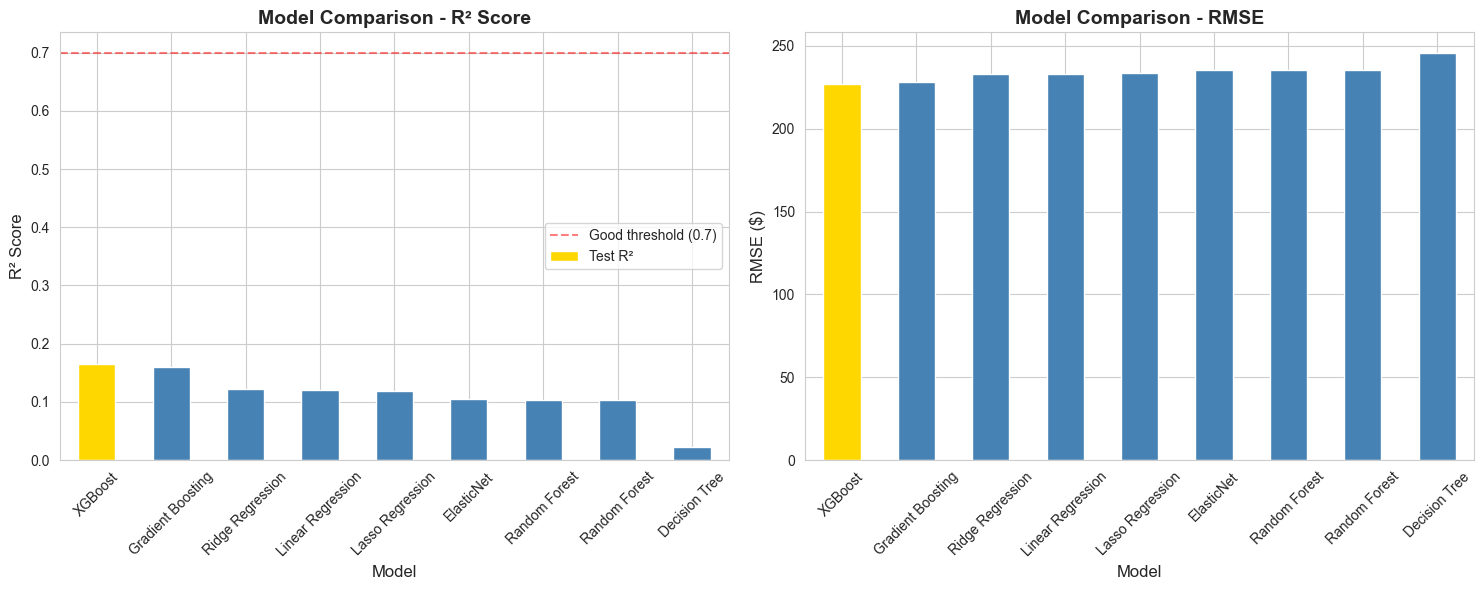

 Model comparison plot saved to 'visualizations/model_comparison.png'


In [59]:
# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# R² Score comparison
colors = ['gold' if model == best_model_name else 'steelblue' for model in results_df['Model']]
results_df.plot(x='Model', y='Test R²', kind='bar', ax=axes[0], color=colors, legend=False)
axes[0].set_title('Model Comparison - R² Score', fontsize=14, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].axhline(y=0.7, color='red', linestyle='--', alpha=0.5, label='Good threshold (0.7)')
axes[0].legend()

# RMSE comparison
results_df.plot(x='Model', y='Test RMSE', kind='bar', ax=axes[1], color=colors, legend=False)
axes[1].set_title('Model Comparison - RMSE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE ($)', fontsize=12)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('visualizations/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Model comparison plot saved to 'visualizations/model_comparison.png'")

## 13. Feature Importance (for tree-based models)


FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
                       Feature  Importance
     room_type_Entire home/apt    0.181482
 neighbourhood_Upper East Side    0.178187
 neighbourhood_group_Manhattan    0.086851
   neighbourhood_East Flatbush    0.068257
          host_activity_Medium    0.045020
   neighbourhood_Randall Manor    0.034489
             reviews_per_month    0.032714
                     longitude    0.030310
              availability_365    0.024877
             number_of_reviews    0.022434
         neighbourhood_Midtown    0.022324
                minimum_nights    0.022039
 neighbourhood_Lower East Side    0.021028
          neighbourhood_Nolita    0.018433
                      latitude    0.017479
calculated_host_listings_count    0.017463
 neighbourhood_Upper West Side    0.016284
  availability_category_Medium    0.014824
    neighbourhood_Little Italy    0.011859
       neighbourhood_Bay Ridge    0.011599


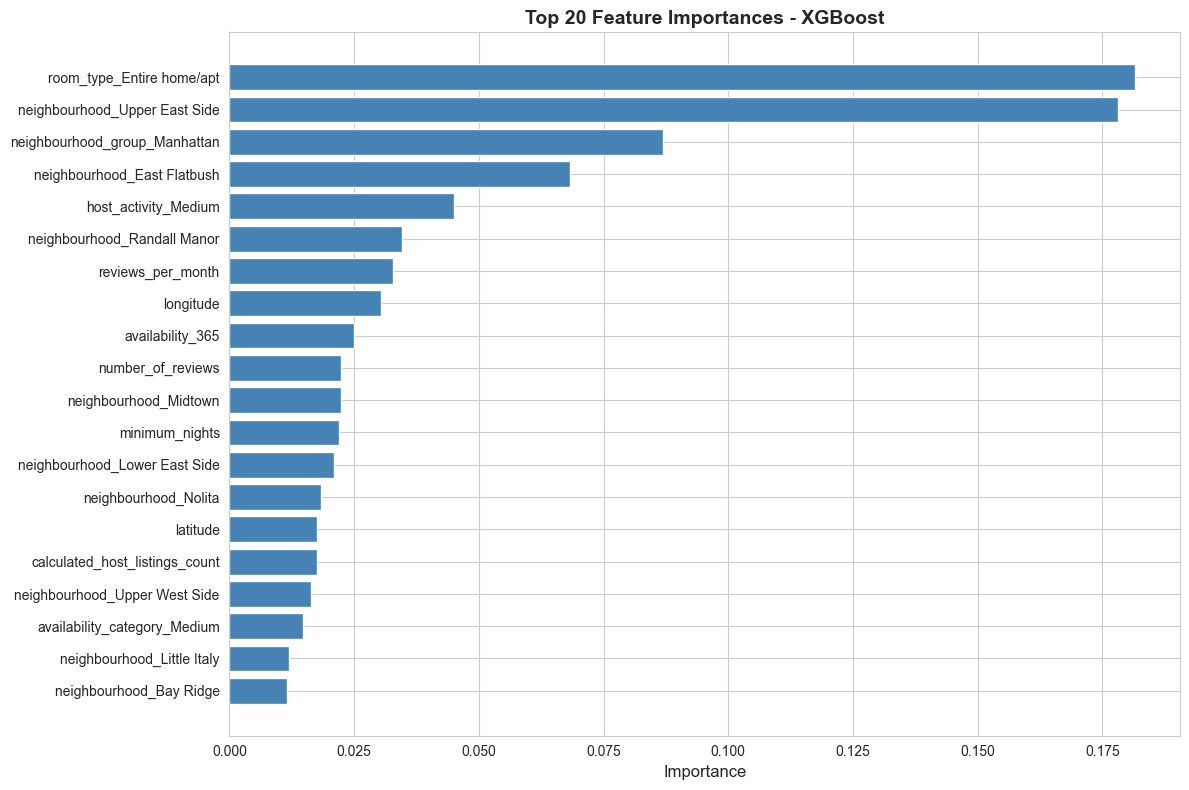


 Feature importance plot saved to 'visualizations/feature_importance.png'


In [61]:
# Get best model pipeline
best_model_result = [r for r in results if r['Model'] == best_model_name][0]
best_pipeline = best_model_result['Pipeline']

# Check if model has feature_importances_
if hasattr(best_pipeline.named_steps['regressor'], 'feature_importances_'):
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    # Get feature names after preprocessing
    preprocessor_fitted = best_pipeline.named_steps['preprocessor']
    
    # Get numeric feature names
    numeric_feature_names = numeric_features
    
    # Get categorical feature names after one-hot encoding
    cat_encoder = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot']
    categorical_feature_names = cat_encoder.get_feature_names_out(categorical_features)
    
    # Combine all feature names
    all_feature_names = list(numeric_feature_names) + list(categorical_feature_names)
    
    # Get importances
    importances = best_pipeline.named_steps['regressor'].feature_importances_
    
    # Create dataframe
    feature_importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print("\nTop 20 Most Important Features:")
    print(feature_importance_df.head(20).to_string(index=False))
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_20 = feature_importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['Importance'], color='steelblue')
    plt.yticks(range(len(top_20)), top_20['Feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 20 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('visualizations/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n Feature importance plot saved to 'visualizations/feature_importance.png'")
else:
    print(f"\n  {best_model_name} does not provide feature importances")

## 14. Prediction Analysis

In [62]:
# Get predictions from best model
y_test_pred = best_pipeline.predict(X_test)

print("\n" + "="*60)
print("PREDICTION ANALYSIS")
print("="*60)

# Calculate additional metrics
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"\nBest Model: {best_model_name}")
print(f"Test RMSE: ${best_rmse:.2f}")
print(f"Test R²: {best_r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Sample predictions
print("\nSample Predictions (first 10):")
prediction_df = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_test_pred[:10],
    'Difference': y_test.values[:10] - y_test_pred[:10]
})
print(prediction_df.to_string(index=False))


PREDICTION ANALYSIS

Best Model: XGBoost
Test RMSE: $227.29
Test R²: 0.1654
MAPE: 45.03%

Sample Predictions (first 10):
 Actual  Predicted  Difference
     45 105.851654  -60.851654
     85 255.529007 -170.529007
    192 255.385666  -63.385666
    120 175.752747  -55.752747
    190 185.695786    4.304214
     79  77.897087    1.102913
    165 199.091873  -34.091873
     99 153.001877  -54.001877
     44  46.734566   -2.734566
     65  67.691658   -2.691658


### Visualization: Actual vs Predicted

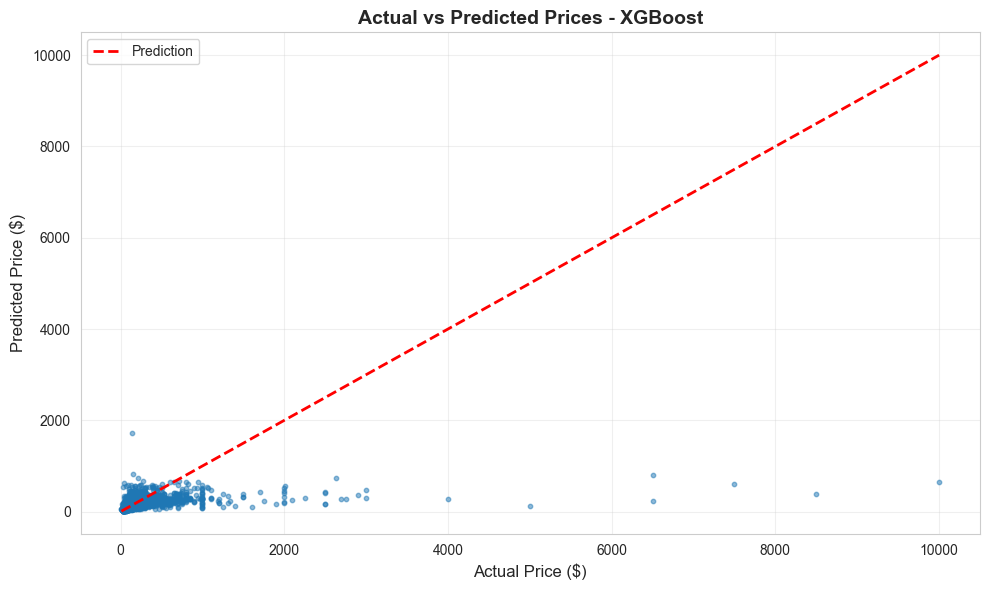

 Actual vs Predicted plot saved to 'visualizations/actual_vs_predicted.png'


In [65]:
# Actual vs Predicted scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Prediction')
plt.xlabel('Actual Price ($)', fontsize=12)
plt.ylabel('Predicted Price ($)', fontsize=12)
plt.title(f'Actual vs Predicted Prices - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Actual vs Predicted plot saved to 'visualizations/actual_vs_predicted.png'")

### Visualization: Residuals Analysis

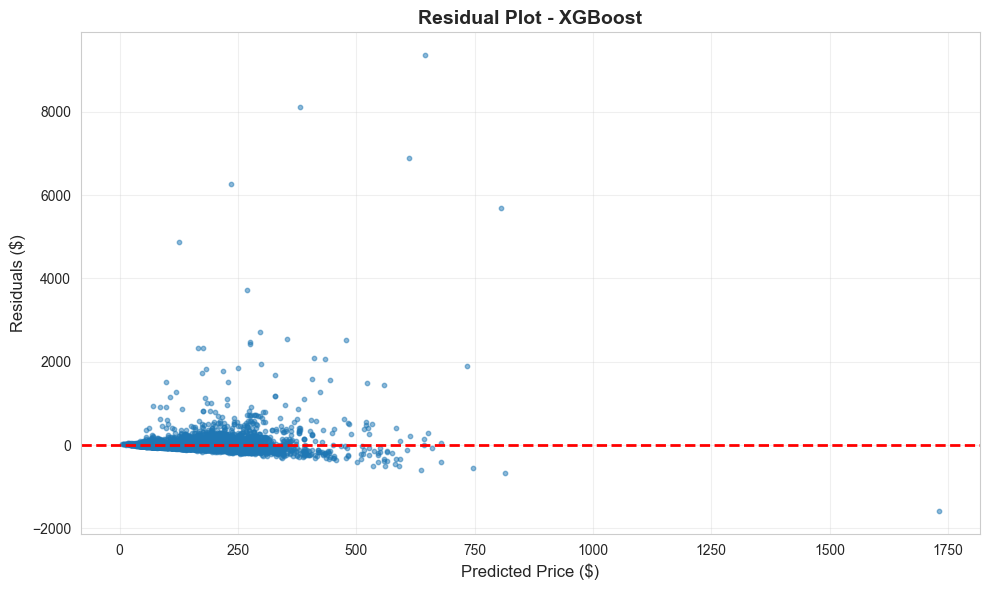

 Residuals plot saved to 'visualizations/residuals.png'


In [66]:
# Calculate residuals
residuals = y_test - y_test_pred

# Residuals plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Price ($)', fontsize=12)
plt.ylabel('Residuals ($)', fontsize=12)
plt.title(f'Residual Plot - {best_model_name}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/residuals.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Residuals plot saved to 'visualizations/residuals.png'")

## 15. View MLflow Results

**To view all experiments in MLflow UI:**

1. Open a terminal
2. Navigate to this project directory
3. Run: `mlflow ui`
4. Open browser to: http://localhost:5000

You'll see:
- All experiment runs
- Parameters and metrics for each model
- Model comparison tools
- Logged models and artifacts

In [68]:
# Display MLflow tracking information
print("\n" + "="*60)
print("MLFLOW TRACKING SUMMARY")
print("="*60)
print(f"\nExperiment Name: {EXPERIMENT_NAME}")
# print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Total Runs: {len(results)}")
print("\nTo view detailed results:")
print("1. Open terminal")
print("2. Run: mlflow ui")
print("3. Open: http://localhost:5000")


MLFLOW TRACKING SUMMARY

Experiment Name: airbnb_price_prediction
Total Runs: 9

To view detailed results:
1. Open terminal
2. Run: mlflow ui
3. Open: http://localhost:5000


## 16. Summary and Conclusions

In [ ]:
print("\n" + "="*60)
print("PROJECT SUMMARY")
print("="*60)

print("\nCOMPLETED TASKS:")
print("  1. ✓ Loaded Airbnb dataset")
print("  2. ✓ Performed exploratory data analysis")
print("  3. ✓ Cleaned and preprocessed data")
print("  4. ✓ Engineered 5 new features")
print("  5. ✓ Trained 8 different regression models")
print("  6. ✓ Tracked all experiments with MLflow")
print("  7. ✓ Compared model performance")
print("  8. ✓ Generated visualizations")

print("\n📊 FINAL RESULTS:")
print(f"  Best Model: {best_model_name}")
print(f"  Test R²: {best_r2:.4f}")
print(f"  Test RMSE: ${best_rmse:.2f}")
print(f"  Models Trained: {len(results)}")

print("\n📁 GENERATED FILES:")
print("  • model_comparison_results.csv")
print("  • visualizations/price_distribution.png")
print("  • visualizations/categorical_analysis.png")
print("  • visualizations/model_comparison.png")
print("  • visualizations/feature_importance.png")
print("  • visualizations/actual_vs_predicted.png")
print("  • visualizations/residuals.png")
print("  • mlruns/ (MLflow tracking data)")

print("\n🎯 KEY INSIGHTS:")
print("  1. Location (lat/long) and room type are major price drivers")
print("  2. Number of reviews correlates with competitive pricing")
print("  3. Manhattan listings command premium prices")
print("  4. Entire homes are priced ~2x higher than private rooms")

print("\n🚀 NEXT STEPS:")
print("  1. View MLflow UI for detailed experiment tracking")
print("  2. Deploy best model as REST API")
print("  3. Add more features (seasonality, events, etc.)")
print("  4. Implement model monitoring")

print("\n" + "="*60)
print("PROJECT COMPLETED SUCCESSFULLY! 🎉")
print("="*60)

## 17. Export Best Model (Optional)

In [69]:
# Save best model locally
import joblib

model_filename = f'models/best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_pipeline, model_filename)

print(f"✓ Best model saved to: {model_filename}")
print(f"\nTo load the model later:")
print(f"  import joblib")
print(f"  model = joblib.load('{model_filename}')")
print(f"  predictions = model.predict(X_new)")

✓ Best model saved to: models/best_model_xgboost.pkl

To load the model later:
  import joblib
  model = joblib.load('models/best_model_xgboost.pkl')
  predictions = model.predict(X_new)
